In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from math import sqrt
from scipy.optimize import minimize

!pip install xgboost
from xgboost import XGBClassifier
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
test=pd.read_csv('/content/Titanic_test.csv')
train=pd.read_csv('/content/Titanic_train.csv')
df = pd.concat([test, train])

In [5]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN


In [6]:
df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,0.0
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,1.0
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0.0
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1.0
890,891,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0.0


In [7]:
df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,891.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.383838
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.486592
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [8]:
df.shape

(1309, 12)

In [9]:
df.dtypes

,0
PassengerId,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object


In [10]:
df['Pclass'].value_counts()

,count
Pclass,
3,709
1,323
2,277


<Axes: xlabel='Pclass', ylabel='count'>

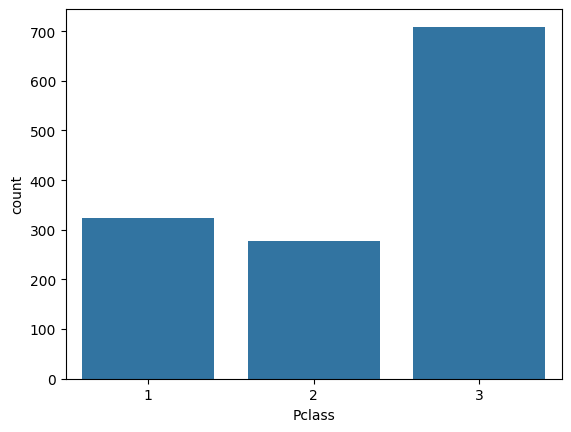

In [11]:
sns.countplot(x=df['Pclass'])

<Axes: >

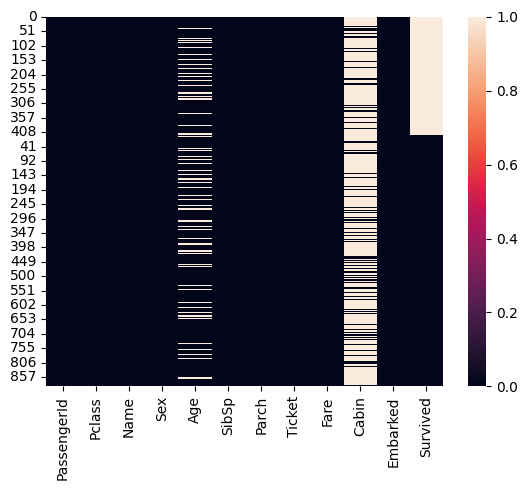

In [12]:
sns.heatmap(df.isna())

In [92]:
# Model Building
# Define X and Y
x=df.iloc[:,:-1] # all rows, all columns except last column
y=df['Pclass']

In [23]:
df['Sex'].replace(['male','female'], [0, 1], inplace=True)
df['Embarked'].fillna(('S'), inplace=True)
df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
df['fare_value']=df['Fare']/50
age_avg = df['Age'].mean()
age_std = df['Age'].std()
df['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
df['age_value']=df['Age']/50
df['family'] = (df['SibSp'] + df['Parch'])/5
df['isAlone'] = 0
df.loc[df['family'] > 0, 'isAlone'] = 1

In [27]:
delete_columns = ['Name','PassengerId','SibSp','Parch','Ticket','Cabin','Age','Fare']
df.drop(delete_columns, axis=1, inplace=True)

In [30]:
train = df[:len(train)]
test = df[len(train):]

trainY = train['Survived']
trainX = train.drop('Survived', axis = 1)
testX = test.drop('Survived', axis = 1)

In [31]:
trainY=np.array(trainY)
trainX=np.array(trainX)
testX=np.array(testX)

In [36]:
xtrain,xvalid,ytrain,yvalid=train_test_split(trainX,trainY,test_size=0.2,random_state=42)

In [57]:
import numpy as np
# Check if ytrain contains NaN values
print(np.isnan(ytrain).sum())

# Remove rows where ytrain contains NaN values
mask = ~np.isnan(ytrain)
xtrain = xtrain[mask]
ytrain = ytrain[mask]
# Replace NaN in ytrain with the mean value (or any custom value)
ytrain = np.where(np.isnan(ytrain), np.nanmean(ytrain), ytrain)

0


In [63]:
model1 = lgb.LGBMRegressor(objective='regression')
model2 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(xtrain, ytrain)
model2.fit(xtrain, ytrain)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 383, number of used features: 7
[LightGBM] [Info] Start training from score 0.407311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)